In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl


In [5]:
nx.__version__

'2.1'

In [6]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import numpy.linalg as LA

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from planning_utils import create_grid_and_edges, a_star_graph
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

from sklearn.neighbors import KDTree
from shapely.geometry import Polygon, Point, LineString

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

In [8]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [9]:
GRD = None
global GRD

In [10]:
class MotionPlanning(Drone):

    def __init__(self, connection, GRD):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL
        
        self.GRD = GRD
        
        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [11]:
def main(GRD):
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    if GRD is None:
        print("GRD is None")
    else:
        print("GRD is not None")
    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn, GRD)
    time.sleep(1)

    drone.start()
    if drone.GRD is not None:
        print("GRD = drone.GRD, not none")
        GRD = drone.GRD
    else:
        print("drone.GRD is none")
    return GRD

In [12]:
from planning_utils import a_star

In [13]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [14]:
def plotgraph(grid, edges, start_ne, goal_ne, start_ne_g, goal_ne_g, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, origin='lower', cmap='Greys') 

    for e in edges:
        p1 = e[0]
        p2 = e[1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    plt.plot(start_ne[1], start_ne[0], 'go', markersize=3, markeredgewidth=5, markerfacecolor='none')
    plt.plot(start_ne_g[1], start_ne_g[0], 'gx', markersize=5, markeredgewidth=3)
    plt.plot(goal_ne[1], goal_ne[0], 'ro', markeredgewidth=5, markerfacecolor='none')
    plt.plot(goal_ne_g[1], goal_ne_g[0], 'rx', markersize=5)
    
    #plt.plot(goal_ne[1], goal_ne[0], 'ro', markersize=3, markeredgewidth=5)
    #plt.plot(goal_ne_g[1], goal_ne_g[0], 'rx', markersize=5, markeredgewidth=3)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')
        plt.scatter(pp[:,1], pp[:,0])

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()

In [15]:
def plotgraphprob(grid, nodes, graph, nmin, emin, start_ne, goal_ne, start_ne_g, goal_ne_g, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, origin='lower', cmap='Greys') 

    # draw nodes
        
    #for n1 in nodes:
    #    plt.scatter(n1[1] - emin, n1[0] - nmin, marker='d', c='magenta', alpha=0.3, linewidths=20)

    for n1 in graph.nodes:
        #plt.scatter(n1[1] - emin, n1[0] - nmin, c='yellow', alpha=0.4, linewidths=10)
        plt.scatter(n1[1], n1[0], c='yellow', alpha=0.4, linewidths=5)
            
    # draw edges
    for (n1, n2) in graph.edges:
        #plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black',linestyle='dashed' , alpha=0.5)
        plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'black',linestyle='dashed' , alpha=0.5)
        
    #plt.plot(start_ne[1], start_ne[0], 'go', markersize=3, fillstyle='none')
    plt.plot(start_ne[1], start_ne[0], 'go', markersize=10, fillstyle='none')
    plt.plot(start_ne_g[1], start_ne_g[0], 'gx', markersize=20)
    plt.plot(goal_ne[1], goal_ne[0], 'ro', markeredgewidth=10, fillstyle='none')
    plt.plot(goal_ne_g[1], goal_ne_g[0], 'rx', markersize=20)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bd', markeredgewidth=2)

    if path is not None:
        
        
        path_pairs = zip(path[:-1], path[1:])
        for (n1, n2) in path_pairs:
            plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'green',linewidth=4)
            #plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green',linewidth=3)
        plt.plot([path[-1][1], goal_ne_g[1]], [path[-1][0], goal_ne_g[0]],linewidth=4)    
        #plt.plot([path[-1][1] - emin, goal_ne_g[1] - emin], [path[-1][0] - nmin, goal_ne_g[0] - nmin],linewidth=3)    

        """
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1] - emin, pp[:, 0] - nmin, 'g')
        plt.scatter(pp[:,1] - emin, pp[:,0] - nmin)
        """
        
    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()

In [16]:
# Graph specific
def convert_graph(edges):
    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1,p2,weight=dist)
    return G

In [17]:
# Graph specific
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    cpshape = (np.array(current_point)).shape[0]
    for p in graph.nodes:
        #npp = np.array(p)
        #cpp = np.array(current_point)
        #print("npp, cpp", npp.shape, cpp.shape, npp, cpp)
        d = LA.norm((np.array(p))[:cpshape] - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    print("closest_point f | current_point: %s, closest_node: %s, dist: %s" %(current_point, closest_point, dist))
    return closest_point

In [18]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [19]:
class Grid():
    def __init__(self, TARGET_ALTITUDE, SAFETY_DISTANCE):
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        grid, edges, north_offset, east_offset = create_grid_and_edges(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("grid# = {0}, edge# = {1}".format(len(grid), len(edges)))
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        with open('colliders.csv') as f:
            first_line = f.readline().strip()
        latlon = first_line.split(',')
        self.lon0 = float(latlon[0].strip().split(' ')[1])
        self.lat0 = float(latlon[1].strip().split(' ')[1])      
        #grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        #self.set_home_position(lat0, lon0, 0)

        self.grid = grid
        self.edges = edges
        self.north_offset = north_offset
        self.east_offset = east_offset

In [20]:
# Probabilistic Roadmap
import time



class GridProbabilistic():
    def __init__(self, TARGET_ALTITUDE, SAFETY_DISTANCE):
        t_0 = time.time()
        self.TARGET_ALTITUDE = TARGET_ALTITUDE
        self.SAFETY_DISTANCE = SAFETY_DISTANCE
        
        self.gn_tree = None
        
        """
        #779.3780925273895 seconds to buil
        self.nk = 20
        self.n_poly = 3
        self.n_samples = 2000
        """
        """
        #graph took 599.6427803039551 seconds to build,
        self.nk = 10
        self.n_poly = 3
        self.n_samples = 3000
        """
        """
        # graph took 438.8356342315674 seconds to build
        self.nk = 8
        self.n_poly = 3
        self.n_samples = 3000
        """
        """
        #graph took 223.3172526359558 seconds to build
        self.nk = 7
        self.n_poly = 2
        self.n_samples = 2000
        """
        """
        2#.# sec
        self.nk = 2
        self.n_poly = 1
        self.n_samples = 50
        """
        """
        # graph took 85.9909451007843 seconds to build
        # plan fail 
        self.nk = 5
        self.n_poly = 2
        self.n_samples = 1000
        """
        
        self.nk = 10
        self.n_poly = 2
        self.n_samples = 4000
        
        """
        self.nk = 3
        self.n_poly = 2
        self.n_samples = 40
        """
        
        
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("grid# = {0}".format(len(grid)))
        print("grid shape = {0}".format(grid.shape))
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        with open('colliders.csv') as f:
            first_line = f.readline().strip()
        latlon = first_line.split(',')
        self.lon0 = float(latlon[0].strip().split(' ')[1])
        self.lat0 = float(latlon[1].strip().split(' ')[1])      
        #grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        #self.set_home_position(lat0, lon0, 0)

        self.grid = grid
        self.north_offset = north_offset
        self.east_offset = east_offset        
        
        #print("data.shape", data.shape)
        #data = data[:100,:]
        #print("data.shape", data.shape)
        self.polygons = self.extract_polygons(data)
        print(len(self.polygons))
        
        self.centers = np.array([(p[0].centroid.x, p[0].centroid.y)for p in self.polygons])
        self.c_tree = KDTree(self.centers, metric="euclidean")

        #self.xmin = np.min(data[:, 0] - data[:, 3]) - self.north_offset
        #self.xmax = np.max(data[:, 0] + data[:, 3]) - self.north_offset

        #self.ymin = np.min(data[:, 1] - data[:, 4]) - self.east_offset
        #self.ymax = np.max(data[:, 1] + data[:, 4]) - self.east_offset

        self.xmin = 0.0
        self.xmax = float(grid.shape[0])
        self.ymin = 0.0
        self.ymax = float(grid.shape[1])
        
        self.zmin = 5.0
        # Limit the z axis for the visualization
        self.zmax = 5.0

        print("X | min = {0}, max = {1}".format(self.xmin, self.xmax))
        print("Y | min = {0}, max = {1}".format(self.ymin, self.ymax))
        print("Z | min = {0}, max = {1}".format(self.zmin, self.zmax))        

        self.sample_nodes()

        
        t0 = time.time()      
        self.graph = self.create_graph(self.nodes)
        print("Number of edges", len(self.graph.edges))
        te = time.time()
        print('graph took {0} seconds to build, pre took {1}, all took {2}'.format(te-t0, t0 - t_0, te - t_0))


    def extract_polygons(self,data):

        polygons = []
        for i in range(data.shape[0]):
            north, east, alt, d_north, d_east, d_alt = data[i, :]

            # TODO: Extract the 4 corners of the obstacle
            # 
            # NOTE: The order of the points matters since
            # `shapely` draws the sequentially from point to point.
            #
            # If the area of the polygon is 0 you've likely got a weird
            # order.
            bottom = north - d_north - self.SAFETY_DISTANCE - self.north_offset
            top = north + d_north + self.SAFETY_DISTANCE - self.north_offset
            left = east - d_east - self.SAFETY_DISTANCE - self.east_offset
            right = east + d_east + self.SAFETY_DISTANCE - self.east_offset            
            bottom_right = (bottom, right)
            top_right = (top, right)
            top_left = (top, left)
            bottom_left = (bottom, left)
            corners = [bottom_right,
                       top_right,
                       top_left,
                       bottom_left]

            # TODO: Compute the height of the polygon
            height = alt + d_alt + self.SAFETY_DISTANCE

            # TODO: Once you've defined corners, define polygons
            p = Polygon(corners)
            polygons.append((p, height))

        return polygons        
        
    def sample_nodes(self):
        # TODO: sample points randomly
        xvals = np.random.uniform(self.xmin, self.xmax, self.n_samples)
        yvals = np.random.uniform(self.ymin, self.ymax, self.n_samples)
        zvals = np.random.uniform(self.zmin, self.zmax, self.n_samples)
        #zvals = np.tile(TARGET_ALTITUDE, num_samples)

        samples = list(zip(xvals, yvals, zvals))        
        nodes =[]
        n_collide_first = 0
        n_collide_other = 0
        n_collide_all = 0
        n_no_collide = 0
        for s in samples:
            po = Point(s[0], s[1])
            npo = np.array(Point(s[0], s[1])).reshape(1, -1)
            
            #nearpidx = c_tree.query(po, k=3, return_distance=False)[0]
            near_polies = self.c_tree.query(npo, k=self.n_poly, return_distance=False)[0]
            is_collision = False
            nidx = 0 
            for near_poly_idx in near_polies:
                nearp, nearph = self.polygons[int(near_poly_idx)]
                if nearp.contains(po):
                    #print("%s contains %s . poly_h:%s, po_h:%s" %(nearp, po, nearph, s[2]))
                    if nearph > s[2]:
                        #print("collision")
                        is_collision = True
                        n_collide_all += 1
                        if nidx > 0:
                            n_collide_other += 1
                            #print("COLLIDE BUT NOT NEAREST POLY sample", s, "near_polies", near_polies)
                            #print("COLLISION WITH: ",nidx, near_poly_idx, nearp, nearph, self.centers[near_poly_idx])
                            for npidx in near_polies:
                                if npidx != near_poly_idx:
                                    nearp2, nearph2 = self.polygons[int(npidx)]
                                    #print("NOT      WITH: ",nidx, npidx, nearp2, nearph2, self.centers[npidx])
                        else:
                            n_collide_first += 1
                        break
                nidx += 1
            if not is_collision:
                n_no_collide += 1
                nodes.append(s)        
        print("# samples, # nodes, # first, # other, # all, # no :", len(samples), len(nodes), n_collide_first, n_collide_other, n_collide_all, n_no_collide)
        """
        for i in range(len(nodes)):
            node = nodes[i]
            print("node:", node, type(node))
            ngrid = (node[0] + self.north_offset, node[1] + self.east_offset, node[2])
            print("ngrid:", ngrid, type(ngrid))
        """
        self.nodes = nodes
        
    def can_connect(self, p1, p2):
        #line = LineString(p1, p2)
        line = LineString([p1, p2])
        for p in self.polygons:
            if line.crosses(p[0]) and p[1] >= min(p1[2], p2[2]):
                return False
        else:
            return True

    def create_graph(self, nodes):
        tg0 = time.time()
        G = nx.Graph()
        n_tree = KDTree(nodes, metric="euclidean")
        self.n_tree = n_tree
        l = len(nodes)
        i = 0
        k = 2
        for p in nodes:
            neighbors = n_tree.query([p], k=self.nk, return_distance=True)

            for idx in range(neighbors[0].shape[1]):
                np_idx = neighbors[1][0][idx]
                neig_dist = neighbors[0][0][idx]
                #print(np_idx, neig_dist)
                np = nodes[np_idx]
                #print(np_idx, neig_dist, np)
                if p == np:
                    #print("same point", p, np)
                    continue
                if self.can_connect(p, np):
                    G.add_edge(p, np, weight=neig_dist)
            i += 1
            if (i % k == 0):
                print(i, "of", l, "gr:", len(G.nodes), " t:", time.time() - tg0)
                k = k * 2
                if k > l:
                    k == l
        return G
    
    def closest_node_debug_other(self, current_point):
        if self.gn_tree is None:
            self.gn_tree = KDTree(self.graph.nodes, metric="euclidean")
        #n_tree = KDTree(self.nodes, metric="euclidean")
        n_tree = self.gn_tree
        cp = current_point
        if len(cp) == 2 and self.TARGET_ALTITUDE is not None:
            cp = (cp[0], cp[1], self.TARGET_ALTITUDE)
        cnq = n_tree.query([cp], k=5, return_distance=True)
        mind = 999999
        cn = None
        ci = -1
        for idx in range(cnq[0].shape[1]):
            cni = cnq[1][0][idx]
            cnd = cnq[0][0][idx]
            cnc = self.nodes[cni]
            print("cp:%s, i:%s, cnc:%s, cnd:%s, cni:%s" %(cp, idx, cnc, cnd, cni))
            if cp == cnc:
                continue
            if cnd < mind:
                mind = cnd
                cn = cnc
                ci = cni

        print("current_point: %s, closest_node: %s" %(cp, cn))
        return cn    

    def closest_node(self, current_point):
        print("len graph nodes: ", len(self.graph.nodes), "type graph nodes: ", type(self.graph.nodes))
        if self.gn_tree is None:
            self.gn_tree = KDTree(self.graph.nodes, metric="euclidean")
        #n_tree = KDTree(self.nodes, metric="euclidean")
        n_tree = self.gn_tree
        cnq = n_tree.query([current_point], k=1, return_distance=True)
        dist = cnq[0][0][0]
        cn_idx = cnq[1][0][0]
        print("cnq:",cnq)
        print("cnq1:",cnq[1])
        print("cnqi 1,0,0:",cn_idx)
        print(type(self.graph.nodes), len(self.graph.nodes))
        cn = self.graph.nodes.index(cn_idx)
        print("closest_node f | current_point: %s, closest_node: %s, dist: %s" %(current_point, cn, dist))
        return cn

main
GRD is None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-1.22397450e+02  3.77924787e+01 -2.00000000e-03], local position [-0.14036374  0.00015594  0.00238188]
creating grid
grid# = 921
grid shape = (921, 921)
North offset = -316, east offset = -445
3845
X | min = 0.0, max = 921.0
Y | min = 0.0, max = 921.0
Z | min = 5.0, max = 5.0
# samples, # nodes, # first, # other, # all, # no : 4000 1633 2357 10 2367 1633
2 of 1633 gr: 20  t: 0.8949520587921143
4 of 1633 gr: 40  t: 1.8035507202148438
8 of 1633 gr: 80  t: 4.671795129776001
16 of 1633 gr: 153  t: 8.220073699951172
32 of 1633 gr: 258  t: 16.620033979415894
64 of 1633 gr: 457  t: 32.65966773033142
128 of 1633 gr: 834  t: 64.60821413993835
256 of 1633 gr: 1200  t: 128.28489923477173
512 of 1633 gr: 1486  t: 249.8064742088318
1024 of 1633 gr: 1587  t: 501.15092849731445
Number of edges 7174
graph took 801.5299136638641 seconds 

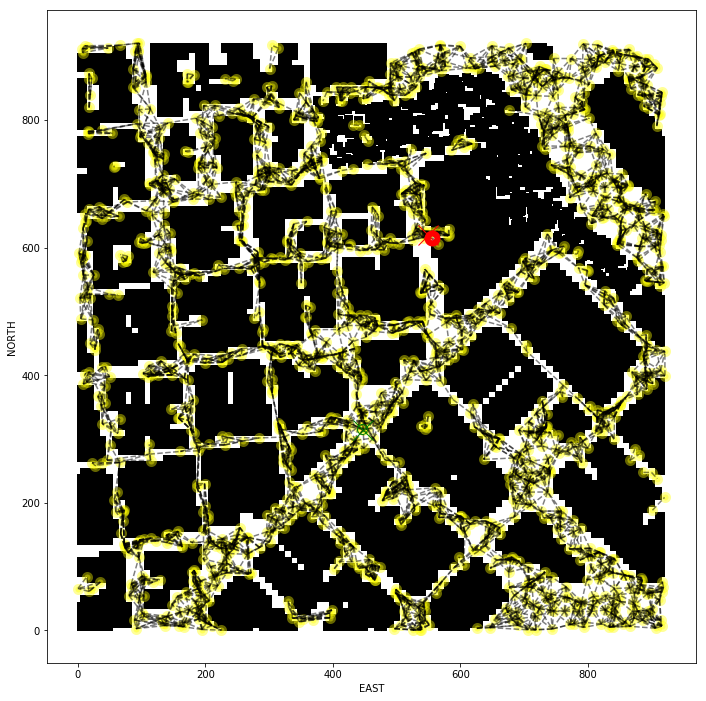

grid_start (316, 445) start_ne_g (314.9100868664074, 447.55708723743294, 5.0)
grid_goal (616, 556) goal_ne_g (619.6060939456667, 549.4026632040916, 5.0)
Found a path.
16 3034.6133868707093


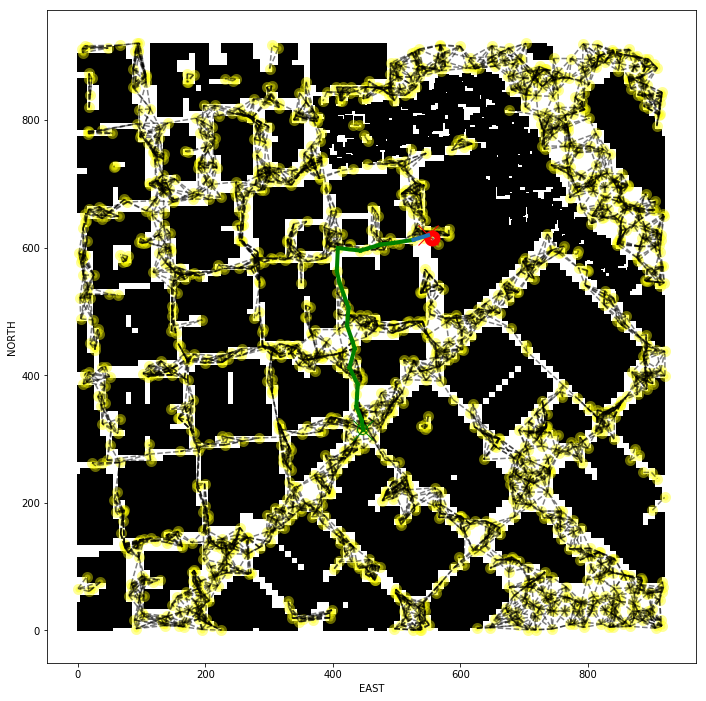

16


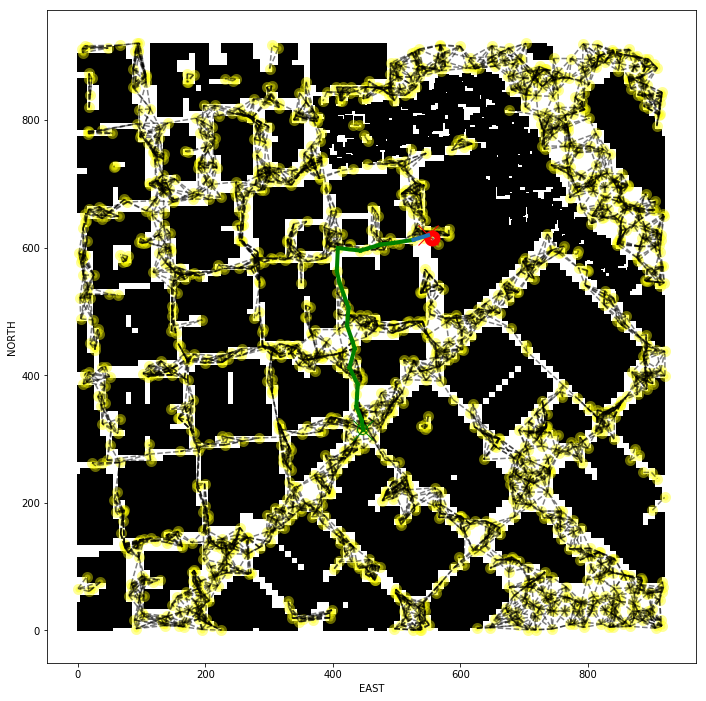

A* path:
(314.9100868664074, 447.55708723743294, 5.0)
(329.15046627314314, 445.3835085722678, 5.0)
(351.15122497877945, 436.9666718051971, 5.0)
(385.7763162999569, 439.0969687092352, 5.0)
(412.0801053250731, 426.17692299325256, 5.0)
(442.04511291608355, 434.23528838890655, 5.0)
(452.8023025043881, 430.9936864919144, 5.0)
(478.1091394478699, 422.26406856743455, 5.0)
(505.7832412507131, 424.5864672685113, 5.0)
(545.9848960578064, 410.2911754594484, 5.0)
(563.2660245935983, 406.2978512332352, 5.0)
(599.5611560968342, 407.92550450468997, 5.0)
(595.5600027486079, 443.25465836338157, 5.0)
(605.0480886690334, 474.6648284556283, 5.0)
(607.3961005631206, 494.3873280253764, 5.0)
(612.3904791116421, 526.3479898547542, 5.0)
Pruned_path:
(314.9100868664074, 447.55708723743294, 5.0)
(329.15046627314314, 445.3835085722678, 5.0)
(351.15122497877945, 436.9666718051971, 5.0)
(385.7763162999569, 439.0969687092352, 5.0)
(412.0801053250731, 426.17692299325256, 5.0)
(442.04511291608355, 434.23528838890655, 

In [21]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    #data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    #voxmap = create_voxmap(data, 1)
    # Define a grid for a particular altitude and safety margin around obstacles
    #grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    #grid, edges, north_offset, east_offset = create_grid_and_edges(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    #print("grid# = {0}, edge# = {1}".format(len(grid), len(edges)))
    #print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    #with open('colliders.csv') as f:
    #    first_line = f.readline().strip()
    #latlon = first_line.split(',')
    #lon0 = float(latlon[0].strip().split(' ')[1])
    #lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    
    if self.GRD is None:
        print("creating grid")
        self.GRD = GridProbabilistic(TARGET_ALTITUDE, SAFETY_DISTANCE)
    else:
        print("grid was already created")
        
    grid = self.GRD.grid
    #edges = self.GRD.edges
    north_offset = self.GRD.north_offset
    east_offset = self.GRD.east_offset
    lon0 = self.GRD.lon0
    lat0 = self.GRD.lat0
    
    self.set_home_position(lat0, lon0, 0)
#     print((lon0, lat0), " vs ", (-north_offset, -east_offset))    
#     print("lla: ",self._latitude, self._longitude, self._altitude)
#     print("gh: ",self.global_home)
#     print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))
    #3d
    #grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])))
    #2d
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("gs: ",grid_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    grid_shape = grid.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * 10.0)
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #3d
        #grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))
        #2d
        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        grid_goal = (616, 556)
        print(grid_goal[1], grid_shape[1] - 1)
        if grid_goal[0] >= grid_shape[0]:
            grid_goal = (grid_shape[0] - 1, grid_goal[1])
        elif grid_goal[0] < 0:
            grid_goal = (0, grid_goal[1])            
        if grid_goal[1] >= grid_shape[1]:
            grid_goal = (grid_goal[0], grid_shape[1] - 1)
        elif grid_goal[1] < 0:
            grid_goal = (grid_goal[0], 0)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        print("gg: ",grid_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    print("gg: ",grid_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Local Start and Goal: ', grid_start, grid_goal)
    #3d
    #path, _ = a_star(voxmap, heuristic, grid_start, grid_goal)
    #2d
    
    #graph = convert_graph(edges)
    graph = self.GRD.graph
    nodes = self.GRD.nodes
    #start_ne_g = closest_point(graph, grid_start)
    #goal_ne_g = closest_point(graph, grid_goal)
    
    grid_start_offset = None
    grid_goal_offset = None
    if len(grid_start) == 2:
        grid_start_offset = (grid_start[0], grid_start[1] , TARGET_ALTITUDE)
        grid_goal_offset = (grid_goal[0], grid_goal[1] , TARGET_ALTITUDE)
    else:
        grid_start_offset = (grid_start[0], grid_start[1] , grid_start[2])
        grid_goal_offset = (grid_goal[0], grid_goal[1] , grid_goal[2])
    """
    if len(grid_start) == 2:
        grid_start_offset = (grid_start[0] + north_offset, grid_start[1] + east_offset, TARGET_ALTITUDE)
        grid_goal_offset = (grid_goal[0] + north_offset, grid_goal[1] + east_offset, TARGET_ALTITUDE)
    else:
        grid_start_offset = (grid_start[0] + north_offset, grid_start[1] + east_offset, grid_start[2])
        grid_goal_offset = (grid_goal[0] + north_offset, grid_goal[1] + east_offset, grid_goal[2])
    """
        
        
        
    #start_ne_g2 = self.GRD.closest_node(grid_start_offset)
    #goal_ne_g2 = self.GRD.closest_node(grid_goal_offset)
    start_ne_g = closest_point(graph, grid_start_offset)
    goal_ne_g = closest_point(graph, grid_goal_offset)    
    #plotgraph(grid, edges, grid_start, grid_goal, start_ne_g, goal_ne_g, goal_list=goal_list)
    plotgraphprob(grid, nodes, graph, north_offset, east_offset, grid_start, grid_goal, start_ne_g, goal_ne_g, goal_list=goal_list)
    #print("grid_start", grid_start, "start_ne_g", start_ne_g, "start_ne_g2", start_ne_g2)
    #print("grid_goal", grid_goal, "goal_ne_g", goal_ne_g, "goal_ne_g2", goal_ne_g2)
    print("grid_start", grid_start, "start_ne_g", start_ne_g)
    print("grid_goal", grid_goal, "goal_ne_g", goal_ne_g)
    
    
    path, cost = a_star_graph(graph, heuristic, start_ne_g, goal_ne_g)
    print(len(path), cost)
    #plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    #plotgraph(grid, edges, grid_start, grid_goal, start_ne_g, goal_ne_g, goal_list=goal_list, path=path)
    plotgraphprob(grid, nodes, graph, north_offset, east_offset, grid_start, grid_goal, start_ne_g, goal_ne_g, goal_list=goal_list, path=path)
    
    pruned_path = prune_path(path)
    print(len(pruned_path))
    #plotgraph(grid, edges, grid_start, grid_goal, start_ne_g, goal_ne_g, goal_list=goal_list, path=pruned_path)
    plotgraphprob(grid, nodes, graph, north_offset, east_offset, grid_start, grid_goal, start_ne_g, goal_ne_g, goal_list=goal_list, path=pruned_path)
    print("A* path:")
    for p in path:
        print(p)
        
    print("Pruned_path:")
    for p in pruned_path:
        print(p)
    #    print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    #waypoints = [[int(np.rint(p[0] + north_offset)), int(np.rint(p[1] + east_offset)), TARGET_ALTITUDE, 0] for p in path]
    #waypoints = [[int(np.rint(p[0] + north_offset)), int(np.rint(p[1] + east_offset)), TARGET_ALTITUDE, 0] for p in pruned_path]
    #not this, is should star from 0,0
    #waypoints = [[int(np.rint(p[0])), int(np.rint(p[1])), TARGET_ALTITUDE, 0] for p in pruned_path]
    

    waypoints = [[int(np.rint(p[0] + north_offset)), int(np.rint(p[1] + east_offset)), TARGET_ALTITUDE, 0] for p in pruned_path]

    print("waypoints")
    print(waypoints)
    for w in waypoints:
        print(w)
    # Set self.waypoints
    self.waypoints = waypoints
    self.GRD.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
GRD = main(GRD)

In [22]:
# send waypoints directly
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    #waypoints = [[6, 6, 5, 0], [10, 6, 5, 0], [49, 22, 5, 0], [78, 76, 5, 0], [108, 121, 5, 0], [130, 125, 5, 0], [174, 125, 5, 0], [210, 105, 5, 0], [272, 93, 5, 0]]

    if self.GRD is not None:
        if self.GRD.waypoints is not None:
            waypoints = self.GRD.waypoints
    
    print("waypoints")
    print(waypoints)
    for w in waypoints:
        print(w)
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
GRD = main(GRD)

main
GRD is not None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
waypoints
[[-1, 3, 5, 0], [13, 0, 5, 0], [35, -8, 5, 0], [70, -6, 5, 0], [96, -19, 5, 0], [126, -11, 5, 0], [137, -14, 5, 0], [162, -23, 5, 0], [190, -20, 5, 0], [230, -35, 5, 0], [247, -39, 5, 0], [284, -37, 5, 0], [280, -2, 5, 0], [289, 30, 5, 0], [291, 49, 5, 0], [296, 81, 5, 0]]
[-1, 3, 5, 0]
[13, 0, 5, 0]
[35, -8, 5, 0]
[70, -6, 5, 0]
[96, -19, 5, 0]
[126, -11, 5, 0]
[137, -14, 5, 0]
[162, -23, 5, 0]
[190, -20, 5, 0]
[230, -35, 5, 0]
[247, -39, 5, 0]
[284, -37, 5, 0]
[280, -2, 5, 0]
[289, 30, 5, 0]
[291, 49, 5, 0]
[296, 81, 5, 0]
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [-1, 3, 5, 0]
waypoint transition
target position [13, 0, 5, 0]
waypoint transition
target position [35, -8, 5, 0]
waypoint transition
target position [70, -6, 5, 0]
waypoint transition
target position [96, -19, 5, 0]
waypoint transition
target position [

In [23]:
main()

TypeError: main() missing 1 required positional argument: 'GRD'

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())